# Air Passengers Prediction

## Abstract

Predicting the number of passengers traveling by air is an important topic in the aviation business and travel economics because it allows airlines to better understand what strategy they should develop to meet passenger demand for air travel. Accurate prediction is the key to success for airlines in developing and improving their business models.

## Main Objective

The main objective of the project is to build a model that will be able to forecast the demand for air travel (passenger traffic) in the United States for the next 12 months based on data from the past 12 years.

## Project Workflow:

1. Data Loading and Exploration
  - Data Summary
  - Data Visualization
2. Data Pre-processing
  - Stationarity Analysis
  - Differencing
  - Train Test Split
3. Modeling
  - Holt-Winters Model
  - SARIMA Model
  - FBProphet Model
  - Vanilla LSTM Model
  - Model Evaluation
  - Future Forecast
4. Key Findings and Insights
5. Next Steps

## Data Loading and Exploration

### Data Summary

The data was downloaded from [Kaggle](https://www.kaggle.com/chirag19/air-passengers) and it contains 144 monthly totals of a US air passengers from 1949 to 1960.

The data consists of 2 features:
- **Month** - Month of the year 
- **Passengers** - Total number of passengers travelled on the given month

The Month feature is represented as a string, so it will be converted to datetime format and set as an index.

In [ ]:
# Load the libraries
import numpy as np
import pandas as pd
import statsmodels.tsa.api as smt

import matplotlib.pyplot as plt
%matplotlib inline

from itertools import product

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from fbprophet import Prophet

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

from pandas.tseries.offsets import DateOffset

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the data
data = pd.read_csv('AirPassengers.csv')

In [ ]:
# Explore the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [ ]:
# Set "Month" as index 
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
data.index.freq = 'MS'
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
# Explore data summary
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


### Data Visualization

Data visualization helps to better understand what kind of data will be used in the project, as well as identify the steps that should be taken to prepare the data for the modeling and forecasting process.

The plot shows that the data has a strong upward trend, meaning the number of passengers increases from year to year, and also a seasonality that is explained by increasing the number of passengers in the summer periods and decreasing in the winter periods.

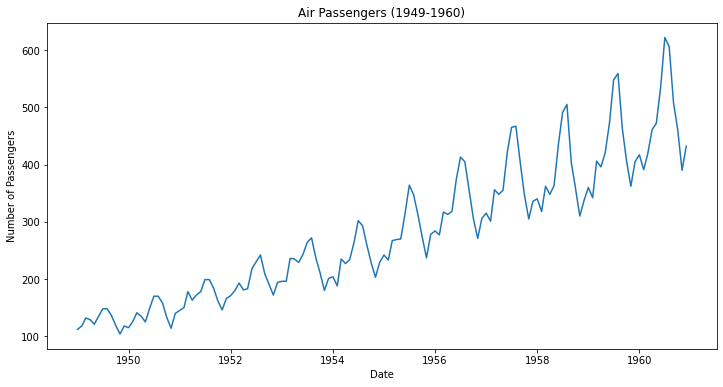

In [ ]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(data)
plt.title('Air Passengers (1949-1960)')
plt.ylabel('Number of Passengers')
plt.xlabel('Date')
plt.show();

## Data Pre-processing

### Stationarity Analysis

Stationarity is a key part of time series analysis. Stationarity means that the way the time series data changes is constant. A stationary time series will not have any trends or seasonal patterns. Stationarity should be checked because it not only simplifies time series modeling, but it is also a basic assumption in many time series analysis methods. In particular, stationarity is assumed for a wide range of time series forecasting methods, including autoregressive moving average (ARMA), ARIMA, and seasonal ARIMA (SARIMA).

The Augmented Dickey-Fuller (ADF) test will be used to test the stationarity of the data. This test generates a p-value that will allow rejecting or not rejecting the null hypothesis that the data are non-stationary. If the null hypothesis is rejected, the alternative hypothesis stating that the data are stationary will be accepted.

Trend decomposition is another useful way to visualize trends in time series data.

In [ ]:
# Decompose the data
stl = STL(data).fit()

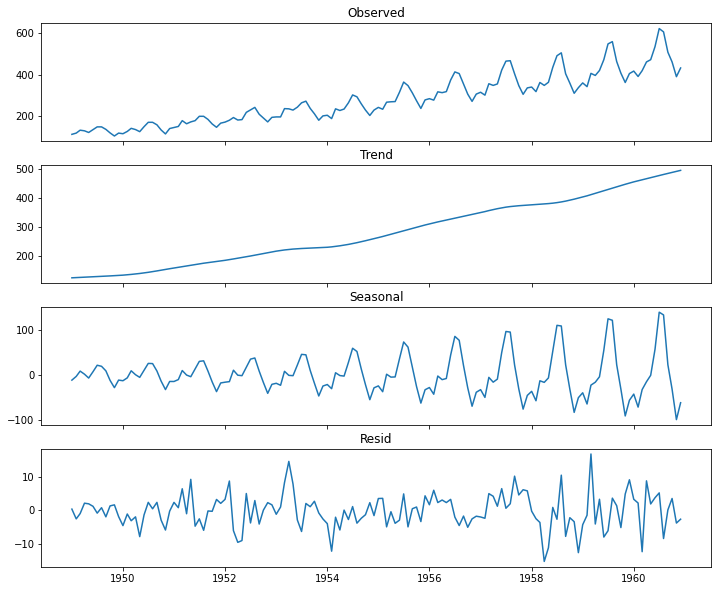

In [ ]:
# Plot the decomposed data components
fig, ax = plt.subplots(4, figsize=(12, 10), sharex=True)

ax[0].plot(stl.observed)
ax[0].set_title('Observed')

ax[1].plot(stl.trend)
ax[1].set_title('Trend')

ax[2].plot(stl.seasonal)
ax[2].set_title('Seasonal')

ax[3].plot(stl.resid)
ax[3].set_title('Resid')

plt.show();

In [ ]:
# Run an Augmented Dickey–Fuller test (ADF) to check if the data is stationary
pvalue = smt.adfuller(data)[1]
print(f'Pvalue = {pvalue:.6f}')

Pvalue = 0.991880


#### Conclusion

The plot of the decomposed data and the ADF test (*p-value = 0.9918*) confirm the non-stationarity of the data.

### Differencing

One of the common approaches to make data stationary is to compute the differences between consecutive observations. This is known as differencing.

Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

In [ ]:
# Get first discrete difference of the data
data_diff = data.diff().fillna(0)
data_diff.head()

,Passengers
Month,
1949-01-01,0.0
1949-02-01,6.0
1949-03-01,14.0
1949-04-01,-3.0
1949-05-01,-8.0


In [ ]:
# Run an Augmented Dickey–Fuller test (ADF) again to check if the data is stationary
pvalue = smt.adfuller(data_diff)[1]
print(f'Pvalue = {pvalue:.6f}')

Pvalue = 0.046620


#### Conclusion

After differenсing the data, the ADF test shows that the p-value is less than 0.05, so it can be claimed with 95% confidence that the differenced data is stationary.

### Train Test Split

As can be seen on the decomposition plot, the seasonality is represented by 12 months, so this period will also be used as the prediction window size, as well as the window size for the SARIMA and LSTM models. In other words, the training data will be 132 months, and the test data will be 12 months.

In [ ]:
# Set the prediction window size equals to 12 months
window_size = 12

In [ ]:
# Split the data to train and test sets
train_val, test_val = data[:-window_size], data[-window_size:]
train_diff, test_diff = data_diff[:-window_size], data_diff[-window_size:]

## Modeling

In [ ]:
# Define help function to transform predicted diff values back to actual values
def get_actual_values(data, prediction, model):
    data_transformed = [data.iloc[i, 0] + prediction[i] for i in range(window_size)]
    return pd.DataFrame(data=data_transformed,
                        index=prediction.index,
                        columns=[model])

---
### Holt-Winters Model

The Holt-Winters method uses exponential smoothing to encode lots of values from the past and use them to predict “typical” values for the present and future. Exponential smoothing refers to the use of an exponentially weighted moving average (EWMA) to “smooth” a time series.

The three aspects of the time series behavior — value, trend, and seasonality — are expressed as three types of exponential smoothing, so Holt-Winters is called triple exponential smoothing. The model predicts a current or future value by computing the combined effects of these three influences.

In [ ]:
# Initiate and train the Holt-Winters Model
holt_model = ExponentialSmoothing(train_diff, 
                             trend='add', 
                             damped=False, 
                             seasonal='add', 
                             seasonal_periods=window_size).fit()

In [ ]:
# Run prediction
holt_pred_diff = holt_model.predict(start=test_diff.index[0], end=test_diff.index[-1])

In [ ]:
# Measure the error of the Holt-Winters model prediction
holt_rmse = np.sqrt(mean_squared_error(test_diff, holt_pred_diff))
print("rmse: ", holt_rmse)

rmse:  22.51714142120167


In [ ]:
# Transform predicted values to the real size values
holt_pred = get_actual_values(test_val, holt_pred_diff, 'Holt-Winters')

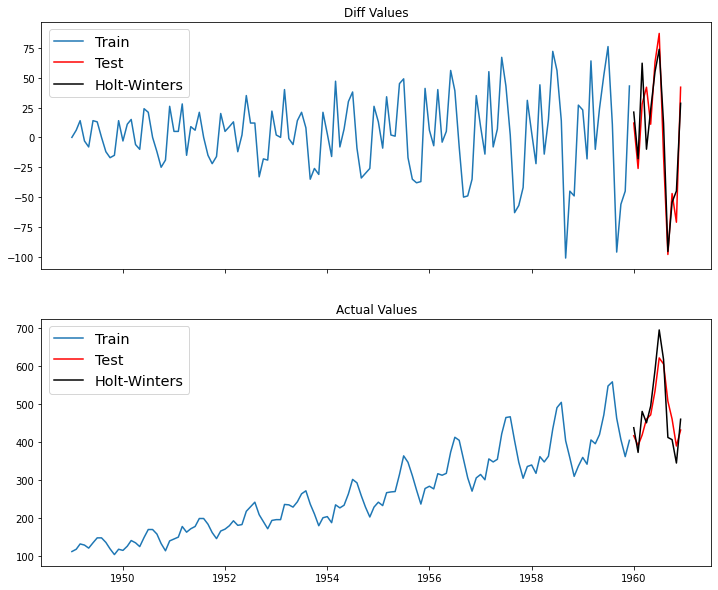

In [ ]:
# Plot the Holt-Winters predictions
fig, ax = plt.subplots(2, figsize=(12, 10), sharex=True)

ax[0].plot(train_diff.index, train_diff, label='Train')
ax[0].plot(test_diff.index, test_diff, label='Test', color='r')
ax[0].plot(holt_pred_diff.index, holt_pred_diff, label='Holt-Winters', color='k')
ax[0].legend(loc='best', fontsize='x-large')
ax[0].set_title('Diff Values')

ax[1].plot(train_val.index, train_val, label='Train')
ax[1].plot(test_val.index, test_val, label='Test', color='r')
ax[1].plot(holt_pred.index, holt_pred, label='Holt-Winters', color='k')
ax[1].legend(loc='best', fontsize='x-large')
ax[1].set_title('Actual Values')

plt.show();

#### Conclusion

The plots above show that in general the model performs quite well. The differenced prediction values on the test period exactly repeat the last training 12-month period. The actual values show that the model has a high error at the peaks of minimum and maximum values.

RMSE indicates that the accuracy of the model is not high enough to accurately predict the future, but it is good enough to get a general picture of what will happen in the future.

---
### SARIMA Model

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of the ARIMA model that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

The seasonal part of the model consists of terms that are very similar to the non-seasonal components of the model, but they involve backshifts of the seasonal period.

In [ ]:
# Define help function to find the best parameters of the SARIMA model
def find_best_sarima(train):
    best_aic = np.inf
    best_order = None
    best_seasonal = None
    best_mdl = None

    p = d = q = range(0, 3)
    pdq = list(product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], window_size) for x in list(product(p, d, q))]

    for param in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                tmp_mdl = SARIMAX(train,
                                  order=param,
                                  seasonal_order=seasonal_param,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = param
                    best_seasonal = seasonal_param
                    best_mdl = tmp_mdl
            except: continue

    print(f'aic: {best_aic:6.2f} | order: {best_order} | seasonal order: {best_seasonal}')
    return best_mdl

In [ ]:
# Initiate and train the SARIMA model
sarima_model = find_best_sarima(train_diff)

aic: 610.64 | order: (1, 2, 2) | seasonal order: (0, 2, 2, 12)


In [ ]:
# Run prediction
sarima_pred_diff = sarima_model.predict(start=test_diff.index[0],
                                        end=test_diff.index[-1],
                                        dynamic=True)

In [ ]:
# Measure the error of the SARIMA model prediction
sarima_rmse = np.sqrt(mean_squared_error(test_diff, sarima_pred_diff))
print("rmse: ", sarima_rmse)

rmse:  22.657681431198927


In [ ]:
# Transform predicted values to the real size values
sarima_pred = get_actual_values(test_val, sarima_pred_diff, 'SARIMA')

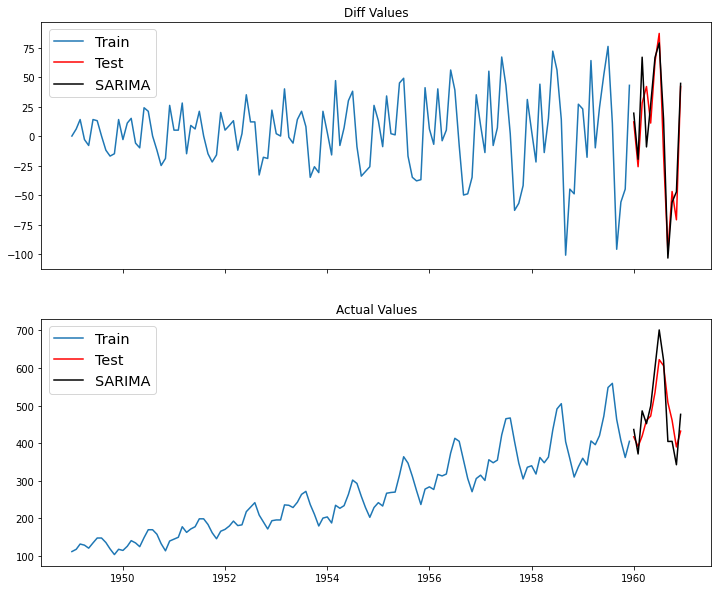

In [ ]:
# Plot the SARIMA predictions
fig, ax = plt.subplots(2, figsize=(12, 10), sharex=True)

ax[0].plot(train_diff.index, train_diff, label='Train')
ax[0].plot(test_diff.index, test_diff, label='Test', color='r')
ax[0].plot(sarima_pred_diff.index, sarima_pred_diff, label='SARIMA', color='k')
ax[0].legend(loc='best', fontsize='x-large')
ax[0].set_title('Diff Values')

ax[1].plot(train_val.index, train_val, label='Train')
ax[1].plot(test_val.index, test_val, label='Test', color='r')
ax[1].plot(sarima_pred.index, sarima_pred, label='SARIMA', color='k')
ax[1].legend(loc='best', fontsize='x-large')
ax[1].set_title('Actual Values')

plt.show();

#### Conclusion

The plots above, as well as the rmse, are almost identical to the results of the Holt-Winters model, but the SARIMA model performed slightly better.

---
### FBProphet Model

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

The input to Prophet is always a dataframe with two columns: **ds** and **y**. The **ds** (datestamp) column should be of a format *YYYY-MM-DD* for a date or *YYYY-MM-DD HH:MM:SS* for a timestamp. The **y** column must be numeric, and represents the measurement to be forecasted.

In [ ]:
# Adjust the normalized data to FBProphet model using reindexing and renaming the columns
prophet = data_diff.reset_index()
prophet.columns = ['ds', 'y']

In [ ]:
# Initiate the train data for the FBProphet model
prophet_train = prophet[:-window_size]

In [ ]:
# Define and fit the FBProphet model
prophet_model = Prophet(seasonality_mode='multiplicative')
prophet_model.fit(prophet_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# Run prediction
future = prophet_model.make_future_dataframe(periods=window_size, freq='M')
forecast = prophet_model.predict(future)

In [ ]:
# Set the original indexes to a new dataframe with predicted values 
forecast.set_index(data_diff.index, inplace=True)

In [ ]:
# Cut the predicted values from the whole dataframe
prophet_pred_diff = forecast['yhat'][-window_size:]

In [ ]:
# Measure the error of the FBProphet model prediction
prophet_rmse = np.sqrt(mean_squared_error(test_diff, prophet_pred_diff))
print("rmse: ", prophet_rmse)

rmse:  23.977944367082586


In [ ]:
# Transform predicted values to the real size values
prophet_pred = get_actual_values(test_val, prophet_pred_diff, 'Prophet')

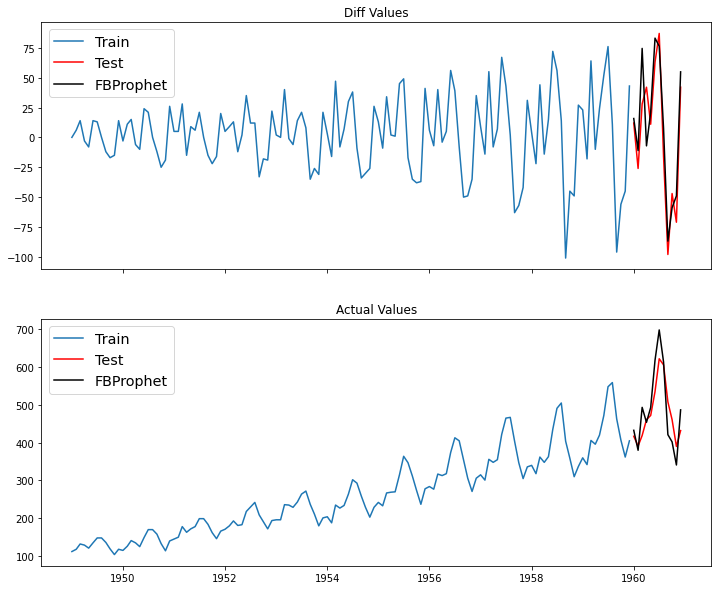

In [ ]:
# Plot the FBProphet predictions
fig, ax = plt.subplots(2, figsize=(12, 10), sharex=True)

ax[0].plot(train_diff.index, train_diff, label='Train')
ax[0].plot(test_diff.index, test_diff, label='Test', color='r')
ax[0].plot(prophet_pred_diff.index, prophet_pred_diff, label='FBProphet', color='k')
ax[0].legend(loc='best', fontsize='x-large')
ax[0].set_title('Diff Values')

ax[1].plot(train_val.index, train_val, label='Train')
ax[1].plot(test_val.index, test_val, label='Test', color='r')
ax[1].plot(prophet_pred.index, prophet_pred, label='FBProphet', color='k')
ax[1].legend(loc='best', fontsize='x-large')
ax[1].set_title('Actual Values')

plt.show();

#### Conclusion

The plots above, as well as the rmse, show that the FBProphet model performed worse than the previous two models.

---
### Vanilla LSTM Model

LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series. LSTMs were developed to deal with the vanishing gradient problem that can be encountered when training traditional RNNs. Relative insensitivity to gap length is an advantage of LSTM over RNNs and other models.

This project will use the Vanilla LSTM model, which is an LSTM model that has one hidden layer of LSTM blocks, and an output layer used for prediction. A Dropout layer will also be added to the model to avoid overfitting.

The data will be scaled using MinMaxScaler to translate each observation in the training set to the given range between zero and one.

The TimeseriesGenerator will be used to prepare the input data for the LSTM model, which will generate sequences of training data equal to 12 months each.

In [ ]:
# Define and fit the scaler to the train set
scaler = MinMaxScaler(feature_range=(-1, 1))
train_scaled = scaler.fit_transform(train_diff)

In [ ]:
# Create input data using TimeseriesGenerator
generator = TimeseriesGenerator(train_scaled, train_scaled, length=window_size, batch_size=6)

In [ ]:
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(window_size, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

In [ ]:
# Compile the LSTM model and show its summary
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the LSTM model
lstm_model.fit_generator(generator, epochs=20, verbose=0)

In [ ]:
# Run prediction
pred_list = []

batch = train_scaled[-window_size:].reshape((1, window_size, 1))

for i in range(window_size):   
    pred_list.append(lstm_model.predict(batch)[0]) 
    batch = np.append(batch[:, 1:, :], [[pred_list[i]]], axis=1)

In [ ]:
# Transform the scaled predicted values back to differences
lstm_pred_diff = scaler.inverse_transform(pred_list)
lstm_pred_diff = np.array(lstm_pred_diff).flatten()
lstm_pred_diff = pd.Series(lstm_pred_diff, index=test_diff.index)

In [ ]:
# Measure the error of the LSTM model prediction
lstm_rmse = np.sqrt(mean_squared_error(test_diff, lstm_pred_diff))
print("rmse: ", lstm_rmse)

rmse:  22.04937851607587


In [ ]:
# Transform predicted values to the real size values
lstm_pred = get_actual_values(test_val, lstm_pred_diff, 'LSTM')

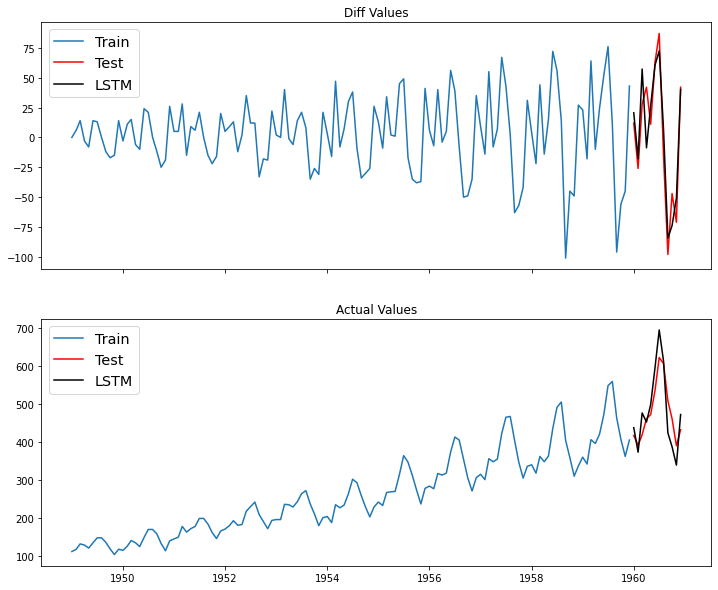

In [ ]:
# Plot the LSTM predictions
fig, ax = plt.subplots(2, figsize=(12, 10), sharex=True)

ax[0].plot(train_diff.index, train_diff, label='Train')
ax[0].plot(test_diff.index, test_diff, label='Test', color='r')
ax[0].plot(lstm_pred_diff.index, lstm_pred_diff, label='LSTM', color='k')
ax[0].legend(loc='best', fontsize='x-large')
ax[0].set_title('Diff Values')

ax[1].plot(train_val.index, train_val, label='Train')
ax[1].plot(test_val.index, test_val, label='Test', color='r')
ax[1].plot(lstm_pred.index, lstm_pred, label='LSTM', color='k')
ax[1].legend(loc='best', fontsize='x-large')
ax[1].set_title('Actual Values')

plt.show();

#### Conclusion

The plots above, as well as the rmse, are almost identical to the results of the Holt-Winters and SARIMA models, but the Vanilla LSTM showed the best results among all the models.

### Model Evaluation

The prediction results on the test set for all 4 models are almost identical.

The FBProphet model performed the worst, while the Vanilla LSTM model performed the best. In general, the predictions of all 4 models are not accurate enough to build a business model on them. But they are good enough to understand airline market trends.

The model with the lowest error, which is the Vanilla LSTM model, will be used as the model for future forecasting.

In [ ]:
# Create a new dataframe with the model errors
rmse_dict = {'Holt-Winters': holt_rmse,
             'SARIMA': sarima_rmse,
             'Prophet': prophet_rmse,
             'LSTM': lstm_rmse}

rmse_eval = pd.DataFrame(rmse_dict, index=['RMSE'])
rmse_eval

,Holt-Winters,SARIMA,Prophet,LSTM
RMSE,22.517141,22.657681,23.977944,22.049379


In [ ]:
# Create a new dataframe with the model differences
model_eval_diff = pd.concat([test_diff, holt_pred_diff, sarima_pred_diff,
                             prophet_pred_diff, lstm_pred_diff], axis=1)
model_eval_diff.columns = ['Passengers', 'Holt-Winters', 'SARIMA', 'Prophet', 'LSTM']
model_eval_diff.astype(np.int)

,Passengers,Holt-Winters,SARIMA,Prophet,LSTM
Month,,,,,
1960-01-01,12,21,19,15,20
1960-02-01,-26,-17,-19,-11,-17
1960-03-01,28,62,66,74,57
1960-04-01,42,-9,-9,-7,-8
1960-05-01,11,23,26,21,26
1960-06-01,63,54,66,83,60
1960-07-01,87,73,78,76,72
1960-08-01,-16,11,14,7,6
1960-09-01,-98,-95,-103,-86,-84


In [ ]:
# Create a new dataframe with the model real size values
model_eval = pd.concat([test_val, holt_pred, sarima_pred, prophet_pred, lstm_pred], axis=1)
model_eval.astype(np.int)

,Passengers,Holt-Winters,SARIMA,Prophet,LSTM
Month,,,,,
1960-01-01,417,438,436,432,437
1960-02-01,391,373,371,379,373
1960-03-01,419,481,485,493,476
1960-04-01,461,451,451,453,452
1960-05-01,472,495,498,493,498
1960-06-01,535,589,601,618,595
1960-07-01,622,695,700,698,694
1960-08-01,606,617,620,613,612
1960-09-01,508,412,404,421,423


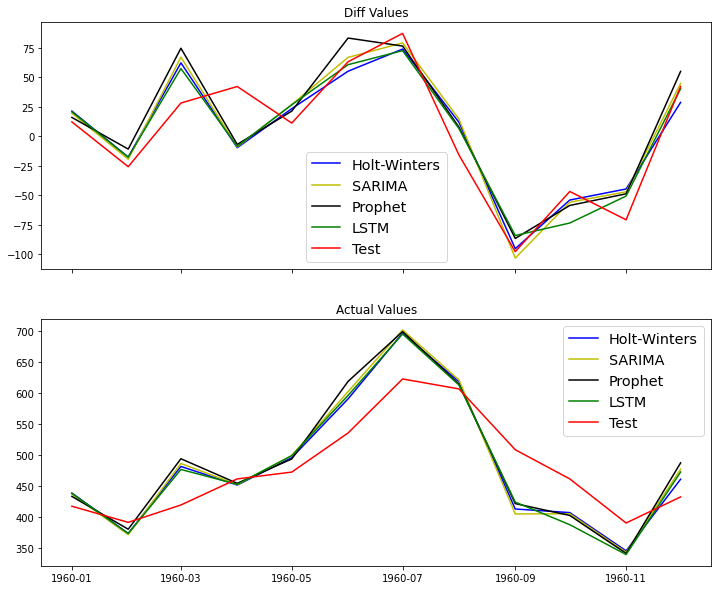

In [ ]:
# Plot the model evaluation
fig, ax = plt.subplots(2, figsize=(12, 10), sharex=True)

ax[0].plot(holt_pred_diff.index, holt_pred_diff, label='Holt-Winters', color='b')
ax[0].plot(sarima_pred_diff.index, sarima_pred_diff, label='SARIMA', color='y')
ax[0].plot(prophet_pred_diff.index, prophet_pred_diff, label='Prophet', color='k')
ax[0].plot(lstm_pred_diff.index, lstm_pred_diff, label='LSTM', color='g')
ax[0].plot(test_diff.index, test_diff, label='Test', color='r')
ax[0].legend(loc='best', fontsize='x-large')
ax[0].set_title('Diff Values')

ax[1].plot(holt_pred.index, holt_pred, label='Holt-Winters', color='b')
ax[1].plot(sarima_pred.index, sarima_pred, label='SARIMA', color='y')
ax[1].plot(prophet_pred.index, prophet_pred, label='Prophet', color='k')
ax[1].plot(lstm_pred.index, lstm_pred, label='LSTM', color='g')
ax[1].plot(test_val.index, test_val, label='Test', color='r')
ax[1].legend(loc='best', fontsize='x-large')
ax[1].set_title('Actual Values')

plt.show();

### Future Forecast

Future forecasts will be performed for the next 12 months using Vanilla LSTM model.

In [ ]:
# Create a new dataframe with a future dates
add_dates = [data_diff.index[-1] + DateOffset(months=x) for x in range(0, 13)]
future_dates = pd.DataFrame(index=add_dates[1:], columns=data_diff.columns)

In [ ]:
# Define a new train set
future_train = data_diff

In [ ]:
# Fit the scaler to the new train set
future_train_scaled = scaler.fit_transform(future_train)

In [ ]:
# Create new input data using TimeseriesGenerator
generator = TimeseriesGenerator(future_train_scaled, future_train_scaled,
                                length=window_size, batch_size=6)

In [ ]:
# Train the LSTM model with the new train set
lstm_model.fit_generator(generator, epochs=20, verbose=0)

In [ ]:
# Forecast the future values
forecast_list = []

batch = future_train_scaled[-window_size:].reshape((1, window_size, 1))

for i in range(window_size):   
    forecast_list.append(lstm_model.predict(batch)[0]) 
    batch = np.append(batch[:, 1:, :], [[forecast_list[i]]], axis=1)

In [ ]:
# Transform the scaled forecasted values back to differences
lstm_future_forecast = scaler.inverse_transform(forecast_list)
lstm_future_forecast = np.array(lstm_future_forecast).flatten()
lstm_future_forecast = pd.Series(lstm_future_forecast, index=future_dates.index)
print(lstm_future_forecast)

1961-01-01     4.044830
1961-02-01   -21.190668
1961-03-01    23.791913
1961-04-01    39.764997
1961-05-01    21.100352
1961-06-01    69.457788
1961-07-01    83.249136
1961-08-01   -56.809610
1961-09-01   -99.176478
1961-10-01   -72.042025
1961-11-01   -59.673404
1961-12-01    37.706919
dtype: float64


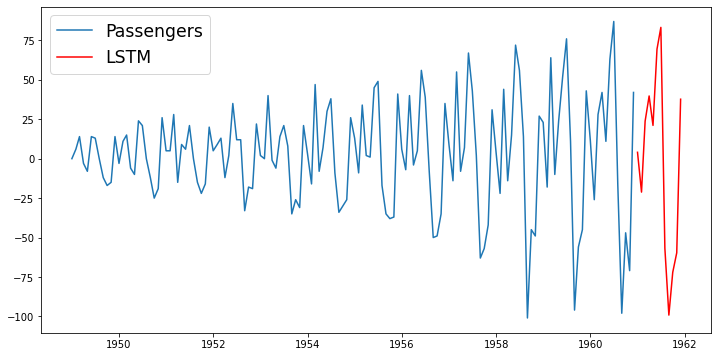

In [ ]:
# Plot the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(data_diff.index, data_diff, label='Passengers')
plt.plot(lstm_future_forecast.index, lstm_future_forecast, label='LSTM', color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.show();

## Key Findings and Insights

An important step in building models based on time series data is to check the data for stationarity and use only stationary data as input. When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary to be effective.

In general all the models perform quite well, but their RMSE indicate that the accuracy of the models is not high enough to accurately predict the future, but it is good enough to get a general picture of what will happen in the future.

The Vanilla LSTM model provides the best results, but it also needs additional tuning.

## Next Steps

Probably inaccurate predictions are due to the small number of observations in the dataset, which are insufficient for efficient model training. This is especially relevant for the LSTM model, which is able to provide good results on large datasets. The next step would be to obtain more observations and expand the given dataset.

In addition, adding more hidden layers to the Vanilla LSTM model, as well as using validation set with EarlyStopping callback to avoid overfitting, would help to get better results.

After expanding the given data with more observations, it would be useful to use other models to train the data, such as RNN, CNN, GRU and XGBoost, before tuning the Vanilla LSTM model.